In [14]:
from time import time
import pickle
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn.utils import clip_grad_norm
from torch.utils.data import DataLoader
import torch.utils.data as Data
import numpy as np
%matplotlib inline

# Load data
with open("data.txt", "rb") as fp:   # Unpickling
    df = pickle.load(fp)
X = df[['left','right']]     
Y = df['target']    

In [15]:
#Seperate to training, validation, and test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state = 101)
validation_size = int(len(X_train) * 0.1)
training_size = len(X_train) - validation_size
X_train, X_validation, Y_train, Y_validation = train_test_split(X_train, Y_train, test_size=validation_size,random_state= 101)
Y_test = Y_test.values
Y_train = Y_train.values
Y_validation = Y_validation.values

In [16]:
print('Training size:',X_train.shape[0])
print('Validation size:',X_validation.shape[0])
print('test size:',X_test.shape[0])

Training size: 1440
Validation size: 160
test size: 400


In [17]:
#Check shape
assert X_train['left'].shape == X_train['right'].shape
assert len(X_train['left']) == len(Y_train)

In [18]:
#Two help function
def one_hot(s):
    nb_digits=201
    batch_size = s.shape[0]
    seqlen = s.shape[1]
    s_onehot = torch.FloatTensor(batch_size,seqlen,nb_digits)
    s_onehot.zero_()
    s_onehot.scatter_(2, s.unsqueeze(2), 1)
    return s_onehot
def padding(data):
    left = [] 
    maxlen= 50
    for i in range(data.shape[0]):
        diff = maxlen - len((data.iloc[i]['left']))
        if diff>=1:
            data.iloc[i]['left']+= [0]*diff
        left.append((data.iloc[i]['left']))
    right = [] 
    maxlen= 50
    for i in range(data.shape[0]):
        diff = maxlen - len((data.iloc[i]['right']))
        if diff>=1:
            data.iloc[i]['right']+= [0]*diff
        right.append((data.iloc[i]['right']))
    return torch.tensor(np.array([right,left])).transpose(1,0)

In [19]:
#Padding and creat the loaders
X_train = padding(X_train)
Y_train = torch.FloatTensor(np.array(Y_train))
train_dataset  = Data.TensorDataset(X_train,Y_train)
train_loader = DataLoader(train_dataset, batch_size=32,shuffle=True)

X_validation = padding(X_validation)
Y_validation = torch.FloatTensor(np.array(Y_validation))
val_dataset  = Data.TensorDataset(X_validation,Y_validation)

X_test = padding(X_test)
Y_test = torch.FloatTensor(np.array(Y_test))
test_dataset  = Data.TensorDataset(X_test,Y_test)

In [55]:
class LSTMEncoder(nn.Module):
    """ Implements the network type integrated within the Siamese RNN architecture. """
    def __init__(self, opt, is_train=False):
        super(LSTMEncoder, self).__init__()
        self.node_size = opt['node_size']
        self.name = 'sim_encoder'
        self.hidden_size= opt['hidden_size']
        self.num_layers= opt['num_layers']
        self.embedding_dim = opt['embedding_dim']
        self.embedding_table = nn.Embedding(num_embeddings=self.node_size, embedding_dim=self.embedding_dim,
                                          padding_idx=0, max_norm=None, scale_grad_by_freq=False, sparse=False)
        self.lstm_rnn = nn.LSTM(input_size=self.embedding_dim, hidden_size=self.hidden_size, num_layers=self.num_layers)
        self.fc1= nn.Linear(self.hidden_size,10)
        self.fc2= nn.Linear(10,2)
    def initialize_hidden_plus_cell(self, batch_size):
        """ Re-initializes the hidden state, cell state, and the forget gate bias of the network. """
        zero_hidden = torch.randn(self.num_layers, batch_size, self.hidden_size)
        zero_cell = torch.randn(self.num_layers, batch_size,self.hidden_size)
        return zero_hidden, zero_cell

    def forward(self, input_data, hidden, cell):
        """ Performs a forward pass through the network. """
        output = self.embedding_table(input_data)
        output, (hidden, cell) = self.lstm_rnn(output, (hidden, cell))
        output = nn.functional.relu(self.fc1(output[-1]))
        output = self.fc2(output) 
        return output, hidden[-1], cell[-1]

In [56]:
class SiameseClassifier(nn.Module):
    """ Sentence similarity estimator implementing a siamese arcitecture. Uses pretrained word2vec embeddings. 
    Different to the paper, the weights are untied, to avoid exploding/ vanishing gradients. """
    def __init__(self, opt, is_train=False):
        super(SiameseClassifier, self).__init__()
        self.learning_rate= opt['learning_rate']
        # Initialize network
        self.encoder_a =  LSTMEncoder(opt, is_train)
        # Initialize network parameters
        self.initialize_parameters()
        # Declare loss function
        self.loss_function = nn.MSELoss()
        # Initialize network optimizers
        self.optimizer_a = optim.Adam(self.encoder_a.parameters(), lr=self.learning_rate,
                                      betas=(0.9, 0.999),weight_decay=0)
        

    def forward(self):
        """ Performs a single forward pass through the siamese architecture. """
        
        # Obtain the input length (each batch consists of padded sentences)
        input_length = self.batch_a.size(0)
        
        # Obtain sentence encodings from each encoder
        hidden_a, cell_a = self.encoder_a.initialize_hidden_plus_cell(self.batch_size)
        output_a, hidden_a, cell_a = self.encoder_a(self.batch_a, hidden_a, cell_a)

        hidden_b, cell_b = self.encoder_a.initialize_hidden_plus_cell(self.batch_size)
        output_b, hidden_b, cell_b = self.encoder_a(self.batch_b, hidden_b, cell_b)

        # Format sentence encodings as 2D tensors
        self.encoding_a = output_a.squeeze()
        self.encoding_b = output_b.squeeze()

        # Obtain similarity score predictions by calculating the Manhattan distance between sentence encodings
        if self.batch_size == 1:
            self.prediction = torch.exp(-torch.norm((self.encoding_a - self.encoding_b), 1))
        else:
            self.prediction = torch.exp(-torch.norm((self.encoding_a - self.encoding_b), 1, 1))
            

    def get_loss(self):
        """ Calculates the MSE loss between the network predictions and the ground truth. """
        # Loss is the L1 norm of the difference between the obtained sentence encodings
        self.loss = self.loss_function(self.prediction, self.labels)

    def load_pretrained_parameters(self,pretrained_state_dict_path):
        """ Loads the parameters learned during the pre-training on the SemEval data. """
        self.encoder_a.load_state_dict(torch.load(pretrained_state_dict_path))
        print('Pretrained parameters have been successfully loaded into the encoder networks.')
    
    def save_lstm(self,path):
        torch.save(self.encoder_a.state_dict(), path)

    def initialize_parameters(self):
        """ Initializes network parameters. """
        state_dict = self.encoder_a.state_dict()
        for key in state_dict.keys():
            if '.weight' in key:
                state_dict[key] = torch.nn.init.xavier_uniform_((state_dict[key]),gain=1)
            if '.bias' in key:
                bias_length = state_dict[key].size()[0]
                start, end = bias_length // 4, bias_length // 2
                state_dict[key][start:end].fill_(2.5)
        self.encoder_a.load_state_dict(state_dict)

    def train_step(self, train_batch_a, train_batch_b, train_labels):
        """ Optimizes the parameters of the active networks, i.e. performs a single training step. """
        # Get batches
        self.batch_a = train_batch_a.transpose(0,1)
        self.batch_b = train_batch_b.transpose(0,1)
        self.labels = train_labels
        self.batch_size = self.batch_a.size(1)
        self.encoder_a.zero_grad() 
        self.forward()
        self.get_loss()
        self.loss.backward()
        clip_grad_norm(self.encoder_a.parameters(), 0.25)
        self.optimizer_a.step()

    def test_step(self, test_batch_a, test_batch_b, test_labels):
        """ Performs a single test step. """
        self.batch_a = test_batch_a.transpose(0,1)
        self.batch_b = test_batch_b.transpose(0,1)
        self.labels = test_labels
        self.batch_size = self.batch_a.size(1)
        self.forward()
        self.get_loss()

In [57]:
num_epochs = 200
pretrain=False
batch_size = 64
opt = {
    'node_size':201,
    'hidden_size':30,
    'num_layers':2,
    'embedding_dim':50,
    'learning_rate':5e-3
}

# Initialize global tracking variables
best_validation_accuracy = 0
epochs_without_improvement = 0
total_train_loss = list()
total_valid_loss = []
avg_trainings = []
avg_valids = []


# Loading model
if pretrain:
    classifier = torch.load('SiameseNN1.pt')
else:
    classifier = SiameseClassifier(opt, is_train=True)
    # Initialize parameters
    classifier.initialize_parameters()

    
for epoch in range(num_epochs):
    
    # Initiate the training data loader
    train_loader = DataLoader(train_dataset, batch_size=batch_size,shuffle=True)
    running_loss = list()
    # Training loop
    for i, (batch_x,label_var) in enumerate(train_loader):
        s1_var = batch_x[:,0,:]
        s2_var  = batch_x[:,1,:]
        #s1_var = one_hot(s1_var)
        #s2_var = one_hot(s2_var)
        classifier.train_step(s1_var, s2_var, label_var)
        train_batch_loss = classifier.loss.data[0]
        running_loss.append(train_batch_loss)
        total_train_loss.append(train_batch_loss)

        if i % 10 == 0 and i != 0:
            running_avg_loss = sum(running_loss) / len(running_loss)
            print('Epoch: %d | Training Batch: %d | Average loss: %.4f' %
                  (epoch, i , running_avg_loss))
            running_loss = []
            

    # Report epoch statistics
    avg_training_accuracy = sum(total_train_loss) / len(total_train_loss)
    print('Average training batch loss at epoch %d: %.4f' % (epoch, avg_training_accuracy))
    avg_trainings.append(avg_training_accuracy) 
    

    # Validate after each epoch; set tracking variables
    if epoch >= 0:
        # Initiate the training data loader
        valid_loader = DataLoader(val_dataset, batch_size=32,shuffle=True)
        
        # Validation loop (i.e. perform inference on the validation set)
        for i, (batch_x,label_var) in enumerate(valid_loader):
            s1_var = batch_x[:,0,:]
            s2_var  = batch_x[:,1,:]
            #s1_var = one_hot(s1_var)
            #s2_var = one_hot(s2_var)
            # Get predictions and update tracking values
            classifier.test_step(s1_var, s2_var, label_var)
            valid_batch_loss = classifier.loss.data[0]
            total_valid_loss.append(valid_batch_loss)

        # Report fold statistics
        avg_valid_accuracy = sum(total_valid_loss) / len(total_valid_loss)
        print('Average validation fold accuracy at epoch %d: %.4f' % (epoch, avg_valid_accuracy))
        avg_valids.append(avg_valid_accuracy)
        # Save network parameters if performance has improved
        if avg_valid_accuracy <= best_validation_accuracy:
            epochs_without_improvement += 1
        else:
            best_validation_accuracy = avg_valid_accuracy
            epochs_without_improvement = 0


/Users/richard/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:78: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
/Users/richard/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch: 0 | Training Batch: 10 | Average loss: 0.2949
Epoch: 0 | Training Batch: 20 | Average loss: 0.2878
Average training batch loss at epoch 0: 0.2945


/Users/richard/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:72: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Average validation fold accuracy at epoch 0: 0.2747
Epoch: 1 | Training Batch: 10 | Average loss: 0.2845
Epoch: 1 | Training Batch: 20 | Average loss: 0.2793
Average training batch loss at epoch 1: 0.2887
Average validation fold accuracy at epoch 1: 0.2820
Epoch: 2 | Training Batch: 10 | Average loss: 0.2945
Epoch: 2 | Training Batch: 20 | Average loss: 0.2838
Average training batch loss at epoch 2: 0.2900
Average validation fold accuracy at epoch 2: 0.2762
Epoch: 3 | Training Batch: 10 | Average loss: 0.2848
Epoch: 3 | Training Batch: 20 | Average loss: 0.2871
Average training batch loss at epoch 3: 0.2891
Average validation fold accuracy at epoch 3: 0.2872
Epoch: 4 | Training Batch: 10 | Average loss: 0.2840
Epoch: 4 | Training Batch: 20 | Average loss: 0.2947
Average training batch loss at epoch 4: 0.2886
Average validation fold accuracy at epoch 4: 0.2850
Epoch: 5 | Training Batch: 10 | Average loss: 0.2925
Epoch: 5 | Training Batch: 20 | Average loss: 0.2926
Average training batch

Epoch: 40 | Training Batch: 20 | Average loss: 0.2406
Average training batch loss at epoch 40: 0.2700
Average validation fold accuracy at epoch 40: 0.2706
Epoch: 41 | Training Batch: 10 | Average loss: 0.2348
Epoch: 41 | Training Batch: 20 | Average loss: 0.2430
Average training batch loss at epoch 41: 0.2693
Average validation fold accuracy at epoch 41: 0.2701
Epoch: 42 | Training Batch: 10 | Average loss: 0.2459
Epoch: 42 | Training Batch: 20 | Average loss: 0.2416
Average training batch loss at epoch 42: 0.2687
Average validation fold accuracy at epoch 42: 0.2695
Epoch: 43 | Training Batch: 10 | Average loss: 0.2478
Epoch: 43 | Training Batch: 20 | Average loss: 0.2391
Average training batch loss at epoch 43: 0.2681
Average validation fold accuracy at epoch 43: 0.2694
Epoch: 44 | Training Batch: 10 | Average loss: 0.2374
Epoch: 44 | Training Batch: 20 | Average loss: 0.2307
Average training batch loss at epoch 44: 0.2673
Average validation fold accuracy at epoch 44: 0.2694
Epoch: 45

Average training batch loss at epoch 79: 0.2333
Average validation fold accuracy at epoch 79: 0.2795
Epoch: 80 | Training Batch: 10 | Average loss: 0.1228
Epoch: 80 | Training Batch: 20 | Average loss: 0.1215
Average training batch loss at epoch 80: 0.2320
Average validation fold accuracy at epoch 80: 0.2802
Epoch: 81 | Training Batch: 10 | Average loss: 0.1065
Epoch: 81 | Training Batch: 20 | Average loss: 0.1377
Average training batch loss at epoch 81: 0.2307
Average validation fold accuracy at epoch 81: 0.2808
Epoch: 82 | Training Batch: 10 | Average loss: 0.1216
Epoch: 82 | Training Batch: 20 | Average loss: 0.1125
Average training batch loss at epoch 82: 0.2293
Average validation fold accuracy at epoch 82: 0.2813
Epoch: 83 | Training Batch: 10 | Average loss: 0.1165
Epoch: 83 | Training Batch: 20 | Average loss: 0.1156
Average training batch loss at epoch 83: 0.2279
Average validation fold accuracy at epoch 83: 0.2819
Epoch: 84 | Training Batch: 10 | Average loss: 0.1173
Epoch: 84

Average training batch loss at epoch 118: 0.1809
Average validation fold accuracy at epoch 118: 0.2978
Epoch: 119 | Training Batch: 10 | Average loss: 0.0387
Epoch: 119 | Training Batch: 20 | Average loss: 0.0345
Average training batch loss at epoch 119: 0.1797
Average validation fold accuracy at epoch 119: 0.2982
Epoch: 120 | Training Batch: 10 | Average loss: 0.0335
Epoch: 120 | Training Batch: 20 | Average loss: 0.0397
Average training batch loss at epoch 120: 0.1785
Average validation fold accuracy at epoch 120: 0.2986
Epoch: 121 | Training Batch: 10 | Average loss: 0.0375
Epoch: 121 | Training Batch: 20 | Average loss: 0.0447
Average training batch loss at epoch 121: 0.1774
Average validation fold accuracy at epoch 121: 0.2988
Epoch: 122 | Training Batch: 10 | Average loss: 0.0353
Epoch: 122 | Training Batch: 20 | Average loss: 0.0405
Average training batch loss at epoch 122: 0.1762
Average validation fold accuracy at epoch 122: 0.2991
Epoch: 123 | Training Batch: 10 | Average los

Epoch: 157 | Training Batch: 10 | Average loss: 0.0223
Epoch: 157 | Training Batch: 20 | Average loss: 0.0157
Average training batch loss at epoch 157: 0.1432
Average validation fold accuracy at epoch 157: 0.3120
Epoch: 158 | Training Batch: 10 | Average loss: 0.0173
Epoch: 158 | Training Batch: 20 | Average loss: 0.0263
Average training batch loss at epoch 158: 0.1424
Average validation fold accuracy at epoch 158: 0.3124
Epoch: 159 | Training Batch: 10 | Average loss: 0.0201
Epoch: 159 | Training Batch: 20 | Average loss: 0.0215
Average training batch loss at epoch 159: 0.1416
Average validation fold accuracy at epoch 159: 0.3126
Epoch: 160 | Training Batch: 10 | Average loss: 0.0240
Epoch: 160 | Training Batch: 20 | Average loss: 0.0240
Average training batch loss at epoch 160: 0.1409
Average validation fold accuracy at epoch 160: 0.3130
Epoch: 161 | Training Batch: 10 | Average loss: 0.0234
Epoch: 161 | Training Batch: 20 | Average loss: 0.0239
Average training batch loss at epoch 1

Average training batch loss at epoch 195: 0.1193
Average validation fold accuracy at epoch 195: 0.3246
Epoch: 196 | Training Batch: 10 | Average loss: 0.0167
Epoch: 196 | Training Batch: 20 | Average loss: 0.0169
Average training batch loss at epoch 196: 0.1188
Average validation fold accuracy at epoch 196: 0.3250
Epoch: 197 | Training Batch: 10 | Average loss: 0.0175
Epoch: 197 | Training Batch: 20 | Average loss: 0.0172
Average training batch loss at epoch 197: 0.1183
Average validation fold accuracy at epoch 197: 0.3254
Epoch: 198 | Training Batch: 10 | Average loss: 0.0120
Epoch: 198 | Training Batch: 20 | Average loss: 0.0131
Average training batch loss at epoch 198: 0.1178
Average validation fold accuracy at epoch 198: 0.3256
Epoch: 199 | Training Batch: 10 | Average loss: 0.0107
Epoch: 199 | Training Batch: 20 | Average loss: 0.0134
Average training batch loss at epoch 199: 0.1173
Average validation fold accuracy at epoch 199: 0.3260


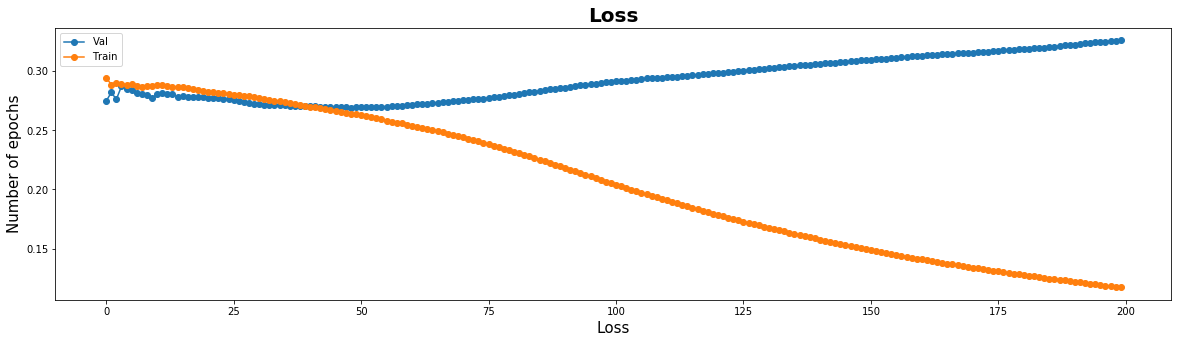

In [59]:
fig, ax = plt.subplots(figsize= (20,5))
ax.plot(avg_valids,marker='o',label='Val')
ax.plot(avg_trainings,marker='o',label='Train')
ax.set_xlabel('Loss',fontsize=15)
ax.set_ylabel('Number of epochs',fontsize=15)
ax.set_title('Loss',fontsize=20,fontweight ="bold")
ax.legend()
#fig.savefig("Loss_graphWithFC2Wit.png")

In [60]:
torch.save(classifier, 'SiameseNNFC1.pt')

/Users/richard/anaconda3/lib/python3.6/site-packages/torch/serialization.py:193: UserWarning: Couldn't retrieve source code for container of type SiameseClassifier. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/Users/richard/anaconda3/lib/python3.6/site-packages/torch/serialization.py:193: UserWarning: Couldn't retrieve source code for container of type LSTMEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
